## Import Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.2 MB/s eta 0:00:00


In [2]:
!pwd

/content


In [17]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer
import itertools

## Dataset Creation and Visualisation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/final_cleaned_data')
df.head()

,Unnamed: 0,embeddings,label
0,0,ex wife threatening suiciderecently left wife ...,1
1,1,need helpjust help im cry hard,1
2,2,im losthello name adam ive struggling year im ...,1
3,3,honestly idi dont know im even feel like nothi...,1
4,4,trigger warning excuse self inflicted burn kno...,1


In [6]:
df.dropna(inplace = True)

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [7]:
df.rename(columns = {'embeddings':'text', 'label':'target'}, inplace = True)


In [8]:
df.head()

,text,target
0,ex wife threatening suiciderecently left wife ...,1
1,need helpjust help im cry hard,1
2,im losthello name adam ive struggling year im ...,1
3,honestly idi dont know im even feel like nothi...,1
4,trigger warning excuse self inflicted burn kno...,1


<Axes: xlabel='target'>

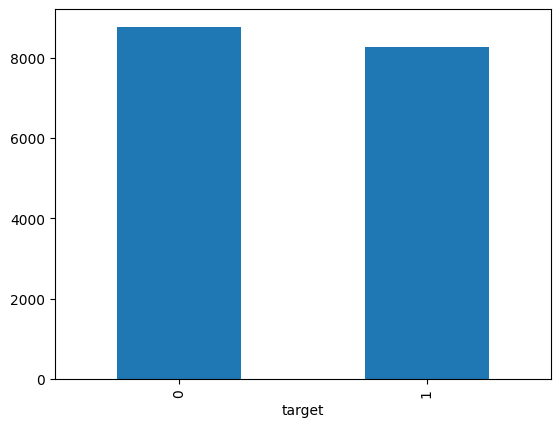

In [9]:
df.groupby(['target']).size().plot.bar()

In [10]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

13631 1704 1704


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

## Modelling

In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['target'].to_list()
        self.texts = [tokenizer(str(text), 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [13]:
df_train.columns

Index(['text', 'target'], dtype='object')

In [14]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

## Training

In [15]:
#training 

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data) 

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 852/852 [18:49<00:00,  1.33s/it]


Epochs: 1 | Train Loss:  0.044                 | Train Accuracy:  0.765                 | Val Loss:  0.012                 | Val Accuracy:  0.970


100%|██████████| 852/852 [19:02<00:00,  1.34s/it]


Epochs: 2 | Train Loss:  0.009                 | Train Accuracy:  0.966                 | Val Loss:  0.007                 | Val Accuracy:  0.978


100%|██████████| 852/852 [19:01<00:00,  1.34s/it]


Epochs: 3 | Train Loss:  0.005                 | Train Accuracy:  0.979                 | Val Loss:  0.006                 | Val Accuracy:  0.978


100%|██████████| 852/852 [18:58<00:00,  1.34s/it]


Epochs: 4 | Train Loss:  0.004                 | Train Accuracy:  0.986                 | Val Loss:  0.005                 | Val Accuracy:  0.979


100%|██████████| 852/852 [19:02<00:00,  1.34s/it]


Epochs: 5 | Train Loss:  0.002                 | Train Accuracy:  0.992                 | Val Loss:  0.005                 | Val Accuracy:  0.976


In [21]:
torch.save(model, 'model_data_txt1.pth')

In [ ]:
model = torch.load('model_data_txt1.pth')


## Evaluation - Test Dataset

In [ ]:
import itertools

In [22]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return output
    
outputs = evaluate(model, df_test)

Test Accuracy:  0.972


In [18]:
from sklearn.metrics import classification_report

def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    predicted_labels = []
    actual_labels = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            _, predictions = torch.max(output, 1)

            # acc = (predictions == test_label).sum().item()
            # total_acc_test += acc

            predictions = np.array([tensor.cpu().numpy() for tensor in predictions])
            test_labels = np.array([tensor.cpu().numpy() for tensor in test_label])

            predicted_labels.append(list(predictions))
            actual_labels.append(list(test_labels))

            
        predicted_labels = list(itertools.chain(*predicted_labels))
        actual_labels = list(itertools.chain(*actual_labels))
        print(classification_report(predicted_labels, actual_labels))
    
    # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return predicted_labels, actual_labels
    
predicted_labels, actual_labels = evaluate(model, df_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       868
           1       0.98      0.96      0.97       836

    accuracy                           0.97      1704
   macro avg       0.97      0.97      0.97      1704
weighted avg       0.97      0.97      0.97      1704



## Inference 

In [20]:
# Define the inference function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def classify_text(text):
    # Tokenize the input text
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt').to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Perform the inference
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prediction = output.argmax(dim = 1)

    # # Convert the output to a Python scalar and return it
    # prediction = prediction.detach().cpu().numpy().item()
    return prediction

# Example usage
text = "friend said im stubborn toxic last thing want hear friend explained much know anymore like fuck dude fourteen see turning fifteen point reached honest scared distanced themself completely given either losing lost everyone ever cared regret ever reaching anybody man make lose weird way feel like deserve clearly apparently toxic honest know feel awful filthy disgusting hate existence fucking detect anything right sorry much going head moment clusterfuck lmaz broken anyways wish wake tonight wish every night wake anyways fucking hate hate much"
prediction = classify_text(text)
print(text)
print(f"Prediction: {prediction}")

friend said im stubborn toxic last thing want hear friend explained much know anymore like fuck dude fourteen see turning fifteen point reached honest scared distanced themself completely given either losing lost everyone ever cared regret ever reaching anybody man make lose weird way feel like deserve clearly apparently toxic honest know feel awful filthy disgusting hate existence fucking detect anything right sorry much going head moment clusterfuck lmaz broken anyways wish wake tonight wish every night wake anyways fucking hate hate much
Prediction: tensor([1], device='cuda:0')
